# 1. Introduction

This study explores the application of machine learning techniques to predict the results of English Premier League matches, specifically focusing on those scheduled for February 3, 2024. We analyzed a comprehensive dataset of past matches spanning from 2000 to 2023, incorporating additional features strongly correlated with the final match outcomes. Furthermore, we integrated the Elo scoring system into our dataset. A detailed training and cross-validation process was conducted on various machine learning techniques, including Logistic Regression, Random Forest, Support Vector Machine (SVM), Extreme Gradient Boosting (XGBoost), and Multilayer Perceptron (MLP). Through our analysis, we compare the performance of each model and datasets. Finally, we conclude the study with a set of predictions for the matches on February 3, 2024.

# 2. Data Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import math
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import pickle
from tqdm import tqdm
# Set to True to use XGBoost (only available on Windows devices)
USE_XGBOOST = True
if USE_XGBOOST:
    from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold

DATA_DIR = "./datasets"

EPL_TRAINING_DATA_CSV = DATA_DIR + "/epl-training.csv"
EPL_TEST_DATA_CSV = DATA_DIR + "/epl-test.csv"
PREMIER_LEAGUE_DATA_CSV = DATA_DIR + "/premier-league-tables.csv"
EXPENDITURE_DATA_CSV = DATA_DIR + "/expenditure_and_income.csv"
TRAVEL_DISTANCE_DATA_CSV = DATA_DIR + "/travel_distance.csv"
RATE_AGE_DATA_CSV = DATA_DIR + "/rating_age.csv"

epl_training_df = pd.read_csv(EPL_TRAINING_DATA_CSV)
epl_test_df = pd.read_csv(EPL_TEST_DATA_CSV)
premier_league_df = pd.read_csv(PREMIER_LEAGUE_DATA_CSV)
expenditure_df = pd.read_csv(EXPENDITURE_DATA_CSV)
travel_distance_df = pd.read_csv(TRAVEL_DISTANCE_DATA_CSV, index_col=0)
rate_age_df = pd.read_csv(RATE_AGE_DATA_CSV)

# 3. Data Transformation & Exploration

## Data exploration with raw data

### Game count for each team as Home/Away

1. the match count differences between home and away is small
2. the match count for each team is not equally distributed

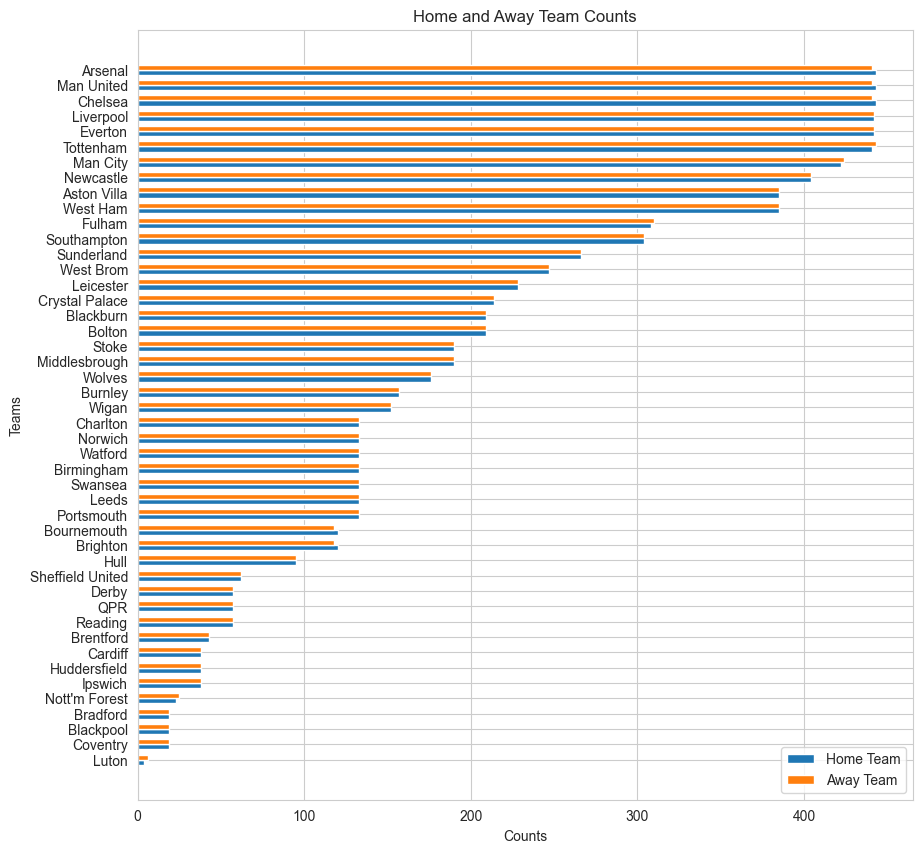

In [35]:
epl_exploration_df = epl_training_df.copy()

home_team_counts = epl_exploration_df['HomeTeam'].value_counts()
away_team_counts = epl_exploration_df['AwayTeam'].value_counts()
team_counts = pd.DataFrame({'HomeTeam': home_team_counts, 'AwayTeam': away_team_counts}).fillna(0)
team_counts = team_counts.sort_values(by='HomeTeam', ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

bar_width = 0.4
space_between_bars = 0.2
index = np.arange(len(team_counts)) * (bar_width + space_between_bars) * 2

bars1 = ax.barh(index - bar_width/2, team_counts['HomeTeam'], bar_width, label='Home Team')
bars2 = ax.barh(index + bar_width/2, team_counts['AwayTeam'], bar_width, label='Away Team')

ax.set_ylabel('Teams')
ax.set_xlabel('Counts')
ax.set_title('Home and Away Team Counts')
ax.set_yticks(index)
ax.set_yticklabels(team_counts.index)
ax.legend()

plt.show()


### Game count for two teams as Home and Away

we can see that the number of games played between two teams is not the same and the difference is quite large, some teams have played against each other more than 20 times, while some teams have never played against each other

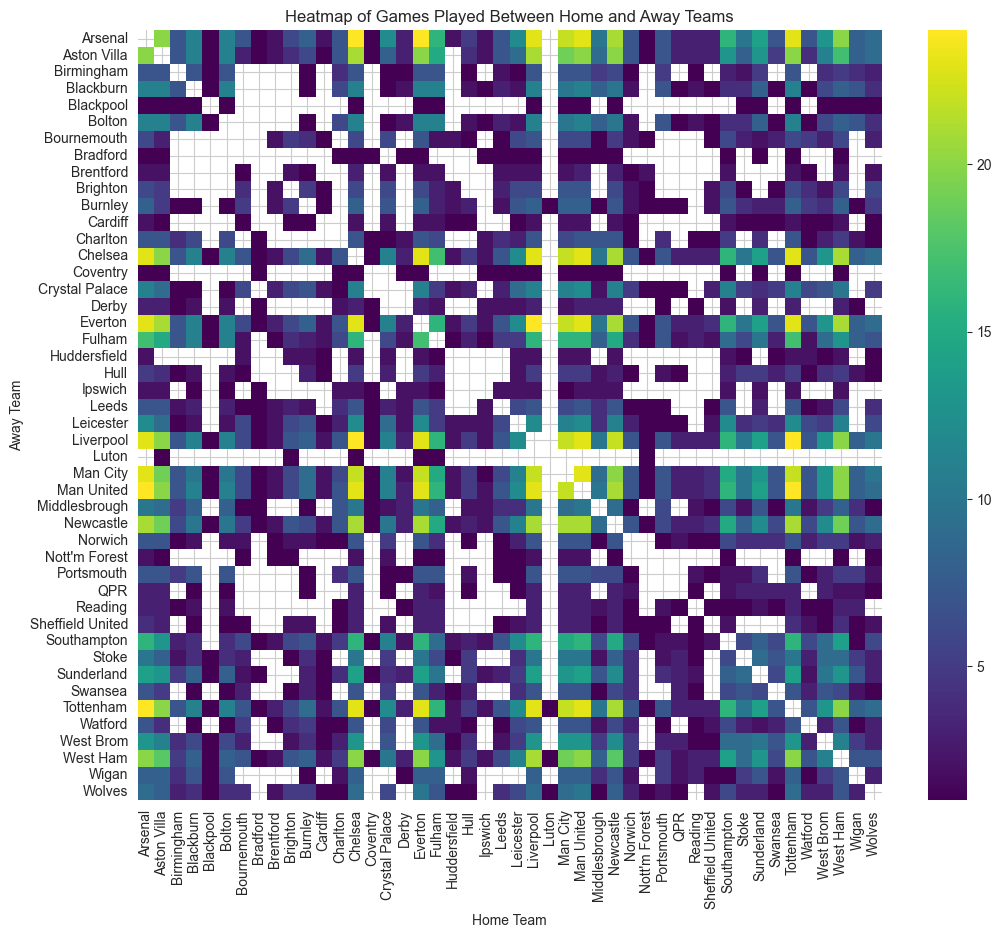

In [36]:
df = epl_exploration_df.copy().dropna()

df['HomeTeam'] = df['HomeTeam'].astype(str)
df['AwayTeam'] = df['AwayTeam'].astype(str)

df['GameCount'] = 1
pivot_table = df.pivot_table(index='AwayTeam', columns='HomeTeam', values='GameCount', aggfunc='sum')
all_teams = sorted(set(df['HomeTeam']).union(set(df['AwayTeam'])))
pivot_table = pivot_table.reindex(index=all_teams, columns=all_teams, fill_value=0)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, cmap="viridis", annot=False)


plt.title('Heatmap of Games Played Between Home and Away Teams')
plt.xlabel('Home Team')
plt.ylabel('Away Team')
plt.show()

### Win rate for each team as Home/Away

we can see that the win rate of each team as Home is normally much higher than the win rate as Away

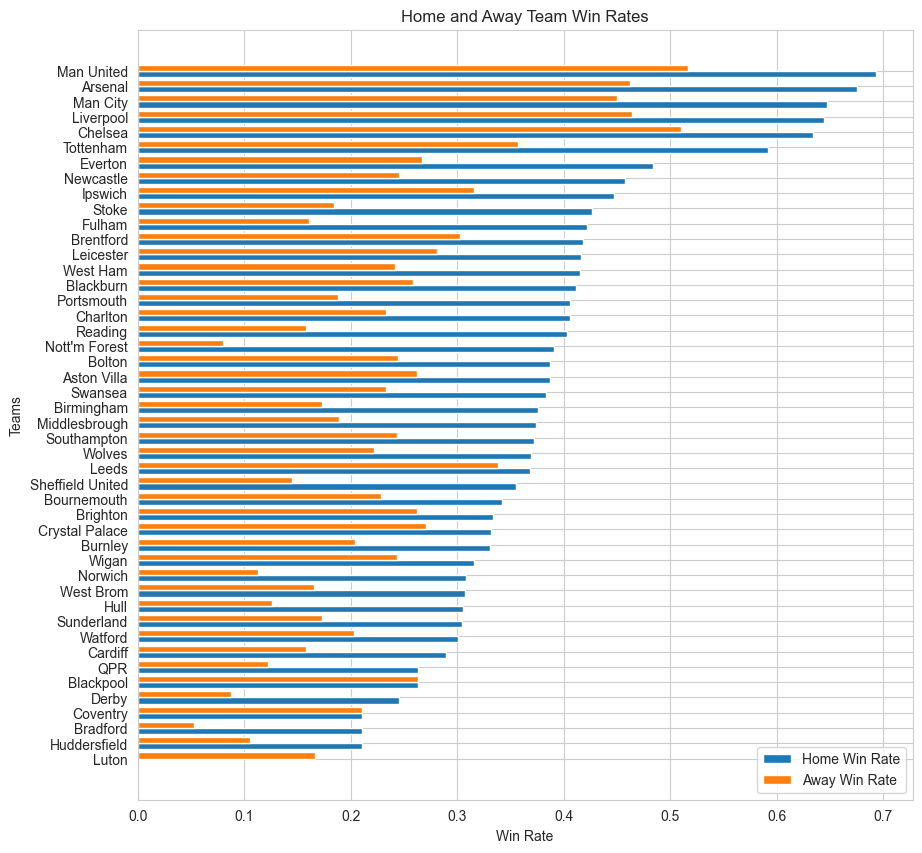

In [37]:
df = epl_exploration_df.copy()  # Assign to a shorter variable for convenience

home_wins = df[df['FTR'] == 'H'].groupby('HomeTeam').size()
total_home_games = df.groupby('HomeTeam').size()
away_wins = df[df['FTR'] == 'A'].groupby('AwayTeam').size()
total_away_games = df.groupby('AwayTeam').size()

# Calculate win rates
home_win_rate = home_wins / total_home_games
away_win_rate = away_wins / total_away_games
win_rates = pd.DataFrame({'HomeWinRate': home_win_rate, 'AwayWinRate': away_win_rate}).fillna(0)
win_rates = win_rates.sort_values(by='HomeWinRate', ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
bar_width = 0.4
index = np.arange(len(win_rates))

bars1 = ax.barh(index - bar_width/2, win_rates['HomeWinRate'], bar_width, label='Home Win Rate')
bars2 = ax.barh(index + bar_width/2, win_rates['AwayWinRate'], bar_width, label='Away Win Rate')

ax.set_ylabel('Teams')
ax.set_xlabel('Win Rate')
ax.set_title('Home and Away Team Win Rates')
ax.set_yticks(index)
ax.set_yticklabels(win_rates.index)

ax.legend(loc='lower right')
ax.xaxis.grid(True)
plt.show()

## Data preprocessing

### unify team names

In [38]:
TEST_TEAM_NAME_TO_TRAIN = {
    'AFC Bournemouth': 'Bournemouth',
    'Arsenal': 'Arsenal',
    'Brentford': 'Brentford',
    'Brighton': 'Brighton',
    'Burnley': 'Burnley',
    'Chelsea': 'Chelsea',
    'Everton': 'Everton',
    'Man Utd': 'Man United',
    'Newcastle': 'Newcastle',
    'Sheff Utd': 'Sheffield United',
    'Nottingham Forest': "Nott'm Forest",
    'Liverpool': 'Liverpool',
    'Man City': 'Man City',
    'Crystal Palace': 'Crystal Palace',
    'Fulham': 'Fulham',
    'Wolves': 'Wolves',
    'Spurs': 'Tottenham',
    'West Ham': 'West Ham',
    'Luton Town': 'Luton',
    'Aston Villa': 'Aston Villa'
}

epl_test_df['HomeTeam'] = epl_test_df['HomeTeam'].map(TEST_TEAM_NAME_TO_TRAIN)
epl_test_df['AwayTeam'] = epl_test_df['AwayTeam'].map(TEST_TEAM_NAME_TO_TRAIN)

### Date to datetime type

In [39]:
epl_training_df['Date'] = pd.to_datetime(epl_training_df['Date'], dayfirst=True, format='mixed')
epl_test_df['Date'] = pd.to_datetime(epl_test_df['Date'], dayfirst=True, format='mixed')

### combine training and test data

In [33]:
epl_processed_df = pd.concat([epl_training_df, epl_test_df])
epl_processed_df.reset_index(inplace=True, drop=True)
epl_processed_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,14.0,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,10.0,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,3.0,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,4.0,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,8.0,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8846,2024-02-03,Chelsea,Wolves,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8847,2024-02-03,Everton,Tottenham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8848,2024-02-03,Man United,West Ham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8849,2024-02-03,Newcastle,Luton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add features

### Team rest time

In [8]:
last_match_time = {}


def calculate_time_difference(row):
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]

    home_rest_time = 0
    away_rest_time = 0

    # Check if the teams have played a match before
    if home_team in last_match_time:
        last_time = last_match_time[home_team]
        time_diff = row["Date"] - last_time
        home_rest_time = time_diff.days
        last_match_time[home_team] = row["Date"]
    else:
        last_match_time[home_team] = row["Date"]

    if away_team in last_match_time:
        last_time = last_match_time[away_team]
        time_diff = row["Date"] - last_time
        away_rest_time = time_diff.days
        last_match_time[away_team] = row["Date"]
    else:
        last_match_time[away_team] = row["Date"]

    return pd.Series([home_rest_time, away_rest_time])


result = epl_processed_df.apply(calculate_time_difference, axis=1)

result.columns = ["home_rest_time", "away_rest_time"]

result["rest_time_diff"] = result["home_rest_time"] - result["away_rest_time"]

epl_processed_df = pd.concat([epl_processed_df, result["rest_time_diff"]], axis=1)

epl_processed_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AST,HC,AC,HF,AF,HY,AY,HR,AR,rest_time_diff
0,2000-08-19,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,4.0,6.0,6.0,13.0,12.0,1.0,2.0,0.0,0.0,0.0
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,5.0,7.0,7.0,19.0,14.0,1.0,2.0,0.0,0.0,0.0
2,2000-08-19,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,9.0,8.0,4.0,15.0,21.0,5.0,3.0,1.0,0.0,0.0
3,2000-08-19,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,6.0,5.0,8.0,11.0,13.0,1.0,1.0,0.0,0.0,0.0
4,2000-08-19,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,6.0,6.0,4.0,21.0,20.0,1.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8846,2024-02-03,Chelsea,Wolves,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8847,2024-02-03,Everton,Tottenham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0
8848,2024-02-03,Man United,West Ham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8849,2024-02-03,Newcastle,Luton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### History

In [9]:
def calculate_rolling_averages(df, n=5, n_same_team=2):
    exclude_columns = [
        "HTR",
        "FTR",
        "Date",
        "HomeTeam",
        "AwayTeam",
        "Referee", 'HomeTeamExpenditure', 'HomeTeamIncome',
        'HomeTeamBalance', 'AwayTeamExpenditure', 'AwayTeamIncome',
        'AwayTeamBalance', 'rest_time_diff'
    ]

    # Columns to calculate rolling averages for
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    columns_to_calculate = [
        col for col in numeric_columns if col not in exclude_columns
    ]

    df = df.sort_values(by="Date")

    # Calculate rolling mean for the last n matches for each team
    for col in columns_to_calculate:
        home_col_name = f"Home{col}_all_avg"
        away_col_name = f"Away{col}_all_avg"

        df[home_col_name] = df.groupby("HomeTeam")[col].transform(
            lambda x: x.rolling(window=n, min_periods=1).mean().shift()
        )
        df[away_col_name] = df.groupby("AwayTeam")[col].transform(
            lambda x: x.rolling(window=n, min_periods=1).mean().shift()
        )

    for col in columns_to_calculate:
        home_col_name = f"Home{col}_same_avg_{n_same_team}"
        away_col_name = f"Away{col}_same_avg_{n_same_team}"
        if col in ["FTHG", "HTHG", "HS", "HST", "HC", "HF", "HY", "HR"]:
            df[home_col_name] = df.groupby(["HomeTeam", "AwayTeam"])[col].transform(
                lambda x: x.rolling(window=n_same_team, min_periods=0)
                .mean()
                .shift()
            )
        else:
            df[away_col_name] = df.groupby(["AwayTeam", "HomeTeam"])[col].transform(
                lambda x: x.rolling(window=n_same_team, min_periods=0)
                .mean()
                .shift()
            )

    return df

# choose 800 to include all previous matches
N = 800
N_same_team = 2
df = calculate_rolling_averages(epl_processed_df, n=N, n_same_team=N_same_team)
del_columns = [
    "FTHG",
    "FTAG",
    "HTHG",
    "HTAG",
    "HTR",
    "Referee",
    "HS",
    "AS",
    "HST",
    "AST",
    "HC",
    "AC",
    "HF",
    "AF",
    "HY",
    "AY",
    "HR",
    "AR",
]
df = df.drop(del_columns, axis=1)

df

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,HomeHST_same_avg_2,AwayAST_same_avg_2,HomeHC_same_avg_2,AwayAC_same_avg_2,HomeHF_same_avg_2,AwayAF_same_avg_2,HomeHY_same_avg_2,AwayAY_same_avg_2,HomeHR_same_avg_2,AwayAR_same_avg_2
0,2000-08-19,Charlton,Man City,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-19,Chelsea,West Ham,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-08-19,Coventry,Middlesbrough,A,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-08-19,Derby,Southampton,D,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-08-19,Leeds,Everton,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,2024-02-03,Arsenal,Liverpool,NaN,1.0,2.167043,1.190045,0.898420,1.601810,0.925508,...,4.5,3.0,2.5,4.5,10.0,10.0,0.5,1.5,0.0,0.0
8841,2024-02-03,Bournemouth,Nott'm Forest,NaN,1.0,1.333333,2.160000,1.550000,0.600000,0.583333,...,4.0,5.0,4.0,6.0,10.0,7.0,1.0,2.0,0.0,0.0
8844,2024-02-03,Brighton,Crystal Palace,NaN,-2.0,1.291667,1.602804,1.291667,1.112150,0.541667,...,4.5,2.0,5.0,2.0,12.0,13.5,0.5,2.0,0.0,0.0
8850,2024-02-03,Sheffield United,Aston Villa,NaN,1.0,1.032258,1.602597,1.258065,1.124675,0.483871,...,2.5,2.0,2.5,4.5,11.5,7.5,1.5,1.0,0.5,0.0


In [10]:
epl_processed_df = df

### Elo Rating

In [11]:
def calculate_expected_score(ra, rb):
    return 1 / (1 + 10 ** ((rb - ra) / 400))

def update_elo(ra, rb, score, k=30):
    ea = calculate_expected_score(ra, rb)
    eb = calculate_expected_score(rb, ra)
    new_ra = ra + k * (score - ea)
    new_rb = rb + k * ((1 - score) - eb)
    return new_ra, new_rb

# Initialize a dictionary to store Elo scores for each team
elo_dict = {}

def calculate_elo_deltas(team, num_games):
    if team not in elo_history or len(elo_history[team]) < num_games:
        return 0  # Not enough history
    return elo_history[team][-2] - elo_history[team][-num_games-2]

# Initialize a dictionary to store Elo history for each team
elo_history = {}

def process_row(row, include_elo_deltas=False):
    home_team, away_team = row['HomeTeam'], row['AwayTeam']
    ftr = row['FTR']
    # Initialize teams with an Elo score of 1500 if they don't have one already
    if home_team not in elo_dict:
        elo_dict[home_team] = 1500
    if away_team not in elo_dict:
        elo_dict[away_team] = 1500

    # Determine match outcome for Elo calculation (1 = home win, 0.5 = draw, 0 = away win)
    if ftr == 'H':
        score = 1
    elif ftr == 'A':
        score = 0
    else:
        score = 0.5

    # Update Elo scores
    curr_home_elo, curr_away_elo = elo_dict[home_team], elo_dict[away_team]
    elo_diff = curr_home_elo - curr_away_elo
    new_home_elo, new_away_elo = update_elo(curr_home_elo, curr_away_elo, score)
    elo_dict[home_team], elo_dict[away_team] = new_home_elo, new_away_elo

    # Update Elo history
    elo_history.setdefault(home_team, [1500] * 11).append(new_home_elo)
    elo_history.setdefault(away_team, [1500] * 11).append(new_away_elo)

    # Calculate Elo deltas - not used in the final model because it's proven to be ineffective
    home_elo_deltas = [calculate_elo_deltas(home_team, i) for i in [1, 5, 10]]
    away_elo_deltas = [calculate_elo_deltas(away_team, i) for i in [1, 5, 10]]

    if include_elo_deltas:
        return pd.Series([new_home_elo, new_away_elo] + [curr_home_elo, curr_away_elo, elo_diff] + home_elo_deltas + away_elo_deltas)
    else:
        return pd.Series([new_home_elo, new_away_elo] + [curr_home_elo, curr_away_elo, elo_diff])

columns = ['AfterMatchHomeElo', 'AfterMatchAwayElo', 'HomeElo', 'AwayElo', 'EloDiff']
epl_processed_df[columns] = epl_processed_df.apply(process_row, axis=1)
epl_processed_df.drop(['AfterMatchHomeElo', 'AfterMatchAwayElo'], axis=1, errors='ignore', inplace=True)
epl_processed_df

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,AwayAC_same_avg_2,HomeHF_same_avg_2,AwayAF_same_avg_2,HomeHY_same_avg_2,AwayAY_same_avg_2,HomeHR_same_avg_2,AwayAR_same_avg_2,HomeElo,AwayElo,EloDiff
0,2000-08-19,Charlton,Man City,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.000000
1,2000-08-19,Chelsea,West Ham,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.000000
2,2000-08-19,Coventry,Middlesbrough,A,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.000000
3,2000-08-19,Derby,Southampton,D,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.000000
4,2000-08-19,Leeds,Everton,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,2024-02-03,Arsenal,Liverpool,NaN,1.0,2.167043,1.190045,0.898420,1.601810,0.925508,...,4.5,10.0,10.0,0.5,1.5,0.0,0.0,1773.800952,1766.203673,7.597279
8841,2024-02-03,Bournemouth,Nott'm Forest,NaN,1.0,1.333333,2.160000,1.550000,0.600000,0.583333,...,6.0,10.0,7.0,1.0,2.0,0.0,0.0,1454.877709,1518.117765,-63.240056
8844,2024-02-03,Brighton,Crystal Palace,NaN,-2.0,1.291667,1.602804,1.291667,1.112150,0.541667,...,2.0,12.0,13.5,0.5,2.0,0.0,0.0,1650.048798,1561.914060,88.134738
8850,2024-02-03,Sheffield United,Aston Villa,NaN,1.0,1.032258,1.602597,1.258065,1.124675,0.483871,...,4.5,11.5,7.5,1.5,1.0,0.5,0.0,1374.995272,1695.841980,-320.846708


### Win/Loss Streak

In [12]:
def add_win_loss_streaks(df):
    df['HomeWinStreak'] = 0
    df['HomeLossStreak'] = 0
    df['AwayWinStreak'] = 0
    df['AwayLossStreak'] = 0

    home_result_mapping = {'H': 'W', 'A': 'L', 'D': 'D', 'N': 'N'}
    away_result_mapping = {'H': 'L', 'A': 'W', 'D': 'D', 'N': 'N'}

    streaks = {team: {'win': 0, 'loss': 0} for team in pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()}

    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Assign the calculated streaks to the DataFrame
        df.at[index, 'HomeWinStreak'] = streaks[home_team]['win']
        df.at[index, 'HomeLossStreak'] = streaks[home_team]['loss']
        df.at[index, 'AwayWinStreak'] = streaks[away_team]['win']
        df.at[index, 'AwayLossStreak'] = streaks[away_team]['loss']

        # Update streaks based on the current row's result
        home_result = home_result_mapping[row['FTR']]
        away_result = away_result_mapping[row['FTR']]

        if home_result == 'W':
            streaks[home_team]['win'] += 1
            streaks[home_team]['loss'] = 0
        elif home_result == 'L':
            streaks[home_team]['win'] = 0
            streaks[home_team]['loss'] += 1
        else:
            streaks[home_team]['win'] = 0
            streaks[home_team]['loss'] = 0

        if away_result == 'W':
            streaks[away_team]['win'] += 1
            streaks[away_team]['loss'] = 0
        elif away_result == 'L':
            streaks[away_team]['win'] = 0
            streaks[away_team]['loss'] += 1
        else:
            streaks[away_team]['win'] = 0
            streaks[away_team]['loss'] = 0

    return df
epl_processed_df['FTR'].fillna('N', inplace=True)
epl_processed_df = add_win_loss_streaks(epl_processed_df)
epl_processed_df

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,AwayAY_same_avg_2,HomeHR_same_avg_2,AwayAR_same_avg_2,HomeElo,AwayElo,EloDiff,HomeWinStreak,HomeLossStreak,AwayWinStreak,AwayLossStreak
0,2000-08-19,Charlton,Man City,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,1500.000000,0.000000,0,0,0,0
1,2000-08-19,Chelsea,West Ham,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,1500.000000,0.000000,0,0,0,0
2,2000-08-19,Coventry,Middlesbrough,A,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,1500.000000,0.000000,0,0,0,0
3,2000-08-19,Derby,Southampton,D,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,1500.000000,0.000000,0,0,0,0
4,2000-08-19,Leeds,Everton,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,1500.000000,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,2024-02-03,Arsenal,Liverpool,N,1.0,2.167043,1.190045,0.898420,1.601810,0.925508,...,1.5,0.0,0.0,1773.800952,1766.203673,7.597279,1,0,2,0
8841,2024-02-03,Bournemouth,Nott'm Forest,N,1.0,1.333333,2.160000,1.550000,0.600000,0.583333,...,2.0,0.0,0.0,1454.877709,1518.117765,-63.240056,1,0,0,1
8844,2024-02-03,Brighton,Crystal Palace,N,-2.0,1.291667,1.602804,1.291667,1.112150,0.541667,...,2.0,0.0,0.0,1650.048798,1561.914060,88.134738,0,0,0,2
8850,2024-02-03,Sheffield United,Aston Villa,N,1.0,1.032258,1.602597,1.258065,1.124675,0.483871,...,1.0,0.5,0.0,1374.995272,1695.841980,-320.846708,0,6,2,0


## Add external data

### Premier League Standings 1993-2023 Data from Kaggle
https://www.kaggle.com/datasets/evangower/english-premier-league-standings

In [13]:
import pandas as pd

mapping = {
    'Arsenal': 'Arsenal',
    'Aston Villa': 'Aston Villa',
    'Barnsley': None,  # No direct match in the first list
    'Birmingham City': 'Birmingham',
    'Blackburn': 'Blackburn',
    'Blackpool': 'Blackpool',
    'Bolton': 'Bolton',
    'Bournemouth': 'Bournemouth',
    'Bradford City': 'Bradford',
    'Brentford': 'Brentford',
    'Brighton': 'Brighton',
    'Burnley': 'Burnley',
    'Cardiff City': 'Cardiff',
    'Charlton Ath': 'Charlton',
    'Chelsea': 'Chelsea',
    'Coventry City': 'Coventry',
    'Crystal Palace': 'Crystal Palace',
    'Derby County': 'Derby',
    'Everton': 'Everton',
    'Fulham': 'Fulham',
    'Huddersfield': 'Huddersfield',
    'Hull City': 'Hull',
    'Ipswich Town': 'Ipswich',
    'Leeds United': 'Leeds',
    'Leicester City': 'Leicester',
    'Liverpool': 'Liverpool',
    'Manchester City': 'Man City',
    'Manchester Utd': 'Man United',
    'Middlesbrough': 'Middlesbrough',
    'Newcastle Utd': 'Newcastle',
    'Norwich City': 'Norwich',
    "Nott'ham Forest": "Nott'm Forest",
    'Oldham Athletic': None,  # No direct match in the first list
    'Portsmouth': 'Portsmouth',
    'QPR': 'QPR',
    'Reading': 'Reading',
    'Sheffield Utd': 'Sheffield United',
    'Sheffield Weds': None,  # No direct match in the first list
    'Southampton': 'Southampton',
    'Stoke City': 'Stoke',
    'Sunderland': 'Sunderland',
    'Swansea City': 'Swansea',
    'Swindon Town': None,  # No direct match in the first list
    'Tottenham': 'Tottenham',
    'Watford': 'Watford',
    'West Brom': 'West Brom',
    'West Ham': 'West Ham',
    'Wigan Athletic': 'Wigan',
    'Wimbledon': None,  # No direct match in the first list
    'Wolves': 'Wolves'
}


df_original = epl_processed_df.copy()

# Load the premier-league-tables.csv DataFrame
df_tables = pd.read_csv('../datasets/premier-league-tables.csv')
df_tables['Team'] = df_tables['Team'].map(mapping)
df_tables['Year'] 
df_original['Date'] = pd.to_datetime(df_original['Date'])
df_original['Year'] = df_original['Date'].dt.year - 1

# Rename columns in df_tables for merging with HomeTeam
df_tables_home = df_tables.copy()
home_columns = {col: f"{col}_Home" for col in df_tables.columns if col not in ['Year']}
df_tables_home.rename(columns=home_columns, inplace=True)
df_original = df_original.merge(df_tables_home, left_on=['HomeTeam', 'Year'], right_on=['Team_Home', 'Year'], how='left')

# Rename columns in df_tables for merging with AwayTeam
df_tables_away = df_tables.copy()
away_columns = {col: f"{col}_Away" for col in df_tables.columns if col not in ['Year']}
df_tables_away.rename(columns=away_columns, inplace=True)
df_original = df_original.merge(df_tables_away, left_on=['AwayTeam', 'Year'], right_on=['Team_Away', 'Year'], how='left')

df_original.drop(['Team_Home', 'Team_Away', 'Year'], axis=1, inplace=True)
df_original

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,GD_Home,Pts_Home,Rk_Away,W_Away,D_Away,L_Away,GF_Away,GA_Away,GD_Away,Pts_Away
0,2000-08-19,Charlton,Man City,H,0.0,NaN,NaN,NaN,NaN,NaN,...,-15.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-19,Chelsea,West Ham,H,0.0,NaN,NaN,NaN,NaN,NaN,...,27.0,75.0,5.0,16.0,9.0,13.0,46.0,53.0,-7.0,57.0
2,2000-08-19,Coventry,Middlesbrough,A,0.0,NaN,NaN,NaN,NaN,NaN,...,-12.0,42.0,9.0,12.0,15.0,11.0,48.0,54.0,-6.0,51.0
3,2000-08-19,Derby,Southampton,D,0.0,NaN,NaN,NaN,NaN,NaN,...,-5.0,52.0,17.0,11.0,8.0,19.0,37.0,64.0,-27.0,41.0
4,2000-08-19,Leeds,Everton,H,0.0,NaN,NaN,NaN,NaN,NaN,...,28.0,67.0,14.0,11.0,10.0,17.0,42.0,47.0,-5.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8846,2024-02-03,Arsenal,Liverpool,N,1.0,2.167043,1.190045,0.898420,1.601810,0.925508,...,45.0,84.0,5.0,19.0,10.0,9.0,75.0,47.0,28.0,67.0
8847,2024-02-03,Bournemouth,Nott'm Forest,N,1.0,1.333333,2.160000,1.550000,0.600000,0.583333,...,-34.0,39.0,16.0,9.0,11.0,18.0,38.0,68.0,-30.0,38.0
8848,2024-02-03,Brighton,Crystal Palace,N,-2.0,1.291667,1.602804,1.291667,1.112150,0.541667,...,19.0,62.0,11.0,11.0,12.0,15.0,40.0,49.0,-9.0,45.0
8849,2024-02-03,Sheffield United,Aston Villa,N,1.0,1.032258,1.602597,1.258065,1.124675,0.483871,...,NaN,NaN,7.0,18.0,7.0,13.0,51.0,46.0,5.0,61.0


In [14]:
epl_processed_df = df_original

### Add Expenditure and Income Data

Expenditure and Income (in million Euros, M€) for Each EPL Club During the Transfer Window, Spanning Seasons 2000/01 to 2023/24, as sourced from transfermarkt.co.uk: 
https://www.transfermarkt.co.uk/premier-league/einnahmenausgaben/wettbewerb/GB1/plus/1?ids=a&sa=&saison_id=2023&saison_id_bis=2023&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0

In [15]:
epl_df = epl_processed_df.copy()

# add home team expenditures&income&balance
for club in expenditure_df['Club'].unique():
    club_data = expenditure_df[expenditure_df['Club'] == club]
    for index, row in club_data.iterrows():
        mask = (epl_df['HomeTeam'] == club) & (epl_df['Date'] > row['start_date']) & (epl_df['Date'] < row['end_date'])
        epl_df.loc[mask, 'HomeTeamExpenditure'] = row['Expenditure']
        epl_df.loc[mask, 'HomeTeamIncome'] = row['Income']
        epl_df.loc[mask, 'HomeTeamBalance'] = row['Balance']

# add away team expenditures&incomes&balance
for club in expenditure_df['Club'].unique():
    club_data = expenditure_df[expenditure_df['Club'] == club]
    for index, row in club_data.iterrows():
        mask = (epl_df['AwayTeam'] == club) & (epl_df['Date'] > row['start_date']) & (epl_df['Date'] < row['end_date'])
        epl_df.loc[mask, 'AwayTeamExpenditure'] = row['Expenditure']
        epl_df.loc[mask, 'AwayTeamIncome'] = row['Income']
        epl_df.loc[mask, 'AwayTeamBalance'] = row['Balance']

# Harmonisation of units of quantity and then delete them
for column in epl_df.columns:

    # check for columns 'Expenditure', 'Income', and 'Balance'
    if column in ['HomeTeamExpenditure', 'HomeTeamIncome', 'HomeTeamBalance', 'AwayTeamExpenditure', 'AwayTeamIncome', 'AwayTeamBalance']:
        epl_df[column] = epl_df[column].replace('-', '0')
        epl_df[column] = epl_df[column].astype(str)  

        epl_df[column] = epl_df[column].str.rstrip('m')

        # Convert values ending in 'k' to a number by dividing by 1000
        def convert_k_to_m(value):
            if str(value).endswith('k'):
                return str(float(value.rstrip('k')) / 1000)
            return value
        
        epl_df[column] = epl_df[column].apply(convert_k_to_m)
        epl_df[column] = epl_df[column].astype(float)

epl_df

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,GF_Away,GA_Away,GD_Away,Pts_Away,HomeTeamExpenditure,HomeTeamIncome,HomeTeamBalance,AwayTeamExpenditure,AwayTeamIncome,AwayTeamBalance
0,2000-08-19,Charlton,Man City,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,20.80,0.532,-20.27,20.28,1.460,-18.810
1,2000-08-19,Chelsea,West Ham,H,0.0,NaN,NaN,NaN,NaN,NaN,...,46.0,53.0,-7.0,57.0,52.39,37.720,-14.67,18.65,42.400,23.750
2,2000-08-19,Coventry,Middlesbrough,A,0.0,NaN,NaN,NaN,NaN,NaN,...,48.0,54.0,-6.0,51.0,19.00,26.280,7.28,33.47,10.000,-23.470
3,2000-08-19,Derby,Southampton,D,0.0,NaN,NaN,NaN,NaN,NaN,...,37.0,64.0,-27.0,41.0,13.33,6.880,-6.45,0.00,0.145,0.145
4,2000-08-19,Leeds,Everton,H,0.0,NaN,NaN,NaN,NaN,NaN,...,42.0,47.0,-5.0,43.0,53.15,12.330,-40.82,34.48,35.550,1.070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8846,2024-02-03,Arsenal,Liverpool,N,1.0,2.167043,1.190045,0.898420,1.601810,0.925508,...,75.0,47.0,28.0,67.0,234.94,67.900,-167.04,172.00,60.700,-111.300
8847,2024-02-03,Bournemouth,Nott'm Forest,N,1.0,1.333333,2.160000,1.550000,0.600000,0.583333,...,38.0,68.0,-30.0,38.0,127.69,1.500,-126.19,122.05,64.820,-57.230
8848,2024-02-03,Brighton,Crystal Palace,N,-2.0,1.291667,1.602804,1.291667,1.112150,0.541667,...,40.0,49.0,-9.0,45.0,100.35,195.900,95.55,38.70,0.000,-38.700
8849,2024-02-03,Sheffield United,Aston Villa,N,1.0,1.032258,1.602597,1.258065,1.124675,0.483871,...,51.0,46.0,5.0,61.0,64.45,30.900,-33.55,93.00,32.550,-60.450


In [16]:
epl_processed_df = epl_df

### Add Travel Distance Data

Travel Distance (km) for Away Team: The dataset was generated through computational analysis of geographical coordinates, specifically latitude and longitude, for each stadium, sourced from https://opisthokonta.net/?p=619.

In [17]:
epl_df = epl_processed_df.copy()

epl_df = epl_df.dropna(subset=['HomeTeam', 'AwayTeam'])
epl_df['TravelDistance'] = epl_df.apply(lambda row: travel_distance_df.at[row['HomeTeam'], row['AwayTeam']], axis=1)
epl_df['LogTravelDistance'] = epl_df['TravelDistance'].apply(lambda x: np.log(x))

epl_df

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,GD_Away,Pts_Away,HomeTeamExpenditure,HomeTeamIncome,HomeTeamBalance,AwayTeamExpenditure,AwayTeamIncome,AwayTeamBalance,TravelDistance,LogTravelDistance
0,2000-08-19,Charlton,Man City,H,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,20.80,0.532,-20.27,20.28,1.460,-18.810,269.134114,5.595210
1,2000-08-19,Chelsea,West Ham,H,0.0,NaN,NaN,NaN,NaN,NaN,...,-7.0,57.0,52.39,37.720,-14.67,18.65,42.400,23.750,16.956668,2.830661
2,2000-08-19,Coventry,Middlesbrough,A,0.0,NaN,NaN,NaN,NaN,NaN,...,-6.0,51.0,19.00,26.280,7.28,33.47,10.000,-23.470,237.809824,5.471471
3,2000-08-19,Derby,Southampton,D,0.0,NaN,NaN,NaN,NaN,NaN,...,-27.0,41.0,13.33,6.880,-6.45,0.00,0.145,0.145,223.584544,5.409790
4,2000-08-19,Leeds,Everton,H,0.0,NaN,NaN,NaN,NaN,NaN,...,-5.0,43.0,53.15,12.330,-40.82,34.48,35.550,1.070,99.688036,4.602046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8845,2024-02-03,Brentford,Man City,N,1.0,1.534884,1.186321,1.093023,1.601415,0.697674,...,61.0,89.0,64.85,10.090,-54.76,241.10,114.500,-126.600,256.671192,5.547796
8846,2024-02-03,Arsenal,Liverpool,N,1.0,2.167043,1.190045,0.898420,1.601810,0.925508,...,28.0,67.0,234.94,67.900,-167.04,172.00,60.700,-111.300,284.736088,5.651563
8847,2024-02-03,Bournemouth,Nott'm Forest,N,1.0,1.333333,2.160000,1.550000,0.600000,0.583333,...,-30.0,38.0,127.69,1.500,-126.19,122.05,64.820,-57.230,250.077347,5.521770
8848,2024-02-03,Brighton,Crystal Palace,N,-2.0,1.291667,1.602804,1.291667,1.112150,0.541667,...,-9.0,45.0,100.35,195.900,95.55,38.70,0.000,-38.700,59.687472,4.089122


In [18]:
epl_processed_df = epl_df

### Add EA FIFA Game Team Average Rating and Age Data

Home Team and Away Team Average Rating (Out of 100): The Team Average Rating is calculated for each team from the mean of players individual rating corresponded to each team and each season with data from EA FIFA Video Game.

Home Team and Away Team Average Age: Z normalisation and logarithm of age were performed for average age to transform average age to standardise the data.

Sourced from:

2023-2024 Season https://www.kaggle.com/datasets/stefanoleone992/ea-sports-fc-24-complete-player-dataset

2022-2023 Season https://www.kaggle.com/datasets/stefanoleone992/fifa-23-complete-player-dataset

2021-2022 Season https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset

2020-2021 Season https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset

2019-2020 Season https://www.kaggle.com/datasets/stefanoleone992/fifa-20-complete-player-dataset

2018-2019 Season https://www.kaggle.com/datasets/thec03u5/fifa-18-demo-player-dataset

2015-2018 Season https://www.kaggle.com/datasets/joebeachcapital/fifa-players

2005-2015 Season https://www.kaggle.com/datasets/daguizer/fifa-2021-to-2005-complete-player-attributes

2002-2005 Season Data Collected directly from EA Sports FIFA 2003 game, EA Sports FIFA 2004 game

In [19]:
epl_df = epl_processed_df.copy()

for club in rate_age_df['Club'].unique():
    club_data = rate_age_df[rate_age_df['Club'] == club]

    mean_age_scores = club_data['Age'].mean()
    std_age_scores = club_data['Age'].std()

    for index, row in club_data.iterrows():
        home_team_filter = (epl_df['HomeTeam'] == club) & (epl_df['Date'] > row['Start']) & (epl_df['Date'] < row['End'])
        away_team_filter = (epl_df['AwayTeam'] == club) & (epl_df['Date'] > row['Start']) & (epl_df['Date'] < row['End'])

        # Find rating
        epl_df.loc[home_team_filter, 'HomeTeamRating'] = row['Overall']
        epl_df.loc[away_team_filter, 'AwayTeamRating'] = row['Overall']

        # Normalize age
        if (row['Age'] - mean_age_scores) == 0:
            epl_df.loc[home_team_filter, 'HomeTeamAge'] = 0
            epl_df.loc[away_team_filter, 'AwayTeamAge'] = 0
        else:
            epl_df.loc[home_team_filter, 'HomeTeamAge'] = (math.log(row['Age']) - mean_age_scores) / std_age_scores
            epl_df.loc[away_team_filter, 'AwayTeamAge'] = (math.log(row['Age']) - mean_age_scores) / std_age_scores

epl_df

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,HomeTeamBalance,AwayTeamExpenditure,AwayTeamIncome,AwayTeamBalance,TravelDistance,LogTravelDistance,HomeTeamRating,AwayTeamRating,HomeTeamAge,AwayTeamAge
0,2000-08-19,Charlton,Man City,H,0.0,NaN,NaN,NaN,NaN,NaN,...,-20.27,20.28,1.460,-18.810,269.134114,5.595210,NaN,NaN,NaN,NaN
1,2000-08-19,Chelsea,West Ham,H,0.0,NaN,NaN,NaN,NaN,NaN,...,-14.67,18.65,42.400,23.750,16.956668,2.830661,NaN,NaN,NaN,NaN
2,2000-08-19,Coventry,Middlesbrough,A,0.0,NaN,NaN,NaN,NaN,NaN,...,7.28,33.47,10.000,-23.470,237.809824,5.471471,NaN,NaN,NaN,NaN
3,2000-08-19,Derby,Southampton,D,0.0,NaN,NaN,NaN,NaN,NaN,...,-6.45,0.00,0.145,0.145,223.584544,5.409790,NaN,NaN,NaN,NaN
4,2000-08-19,Leeds,Everton,H,0.0,NaN,NaN,NaN,NaN,NaN,...,-40.82,34.48,35.550,1.070,99.688036,4.602046,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8845,2024-02-03,Brentford,Man City,N,1.0,1.534884,1.186321,1.093023,1.601415,0.697674,...,-54.76,241.10,114.500,-126.600,256.671192,5.547796,72.137931,78.176471,-28.549383,-20.065745
8846,2024-02-03,Arsenal,Liverpool,N,1.0,2.167043,1.190045,0.898420,1.601810,0.925508,...,-167.04,172.00,60.700,-111.300,284.736088,5.651563,74.635135,72.123288,-17.210907,-19.785828
8847,2024-02-03,Bournemouth,Nott'm Forest,N,1.0,1.333333,2.160000,1.550000,0.600000,0.583333,...,-126.19,122.05,64.820,-57.230,250.077347,5.521770,73.172414,74.483871,-27.103954,-41.388950
8848,2024-02-03,Brighton,Crystal Palace,N,-2.0,1.291667,1.602804,1.291667,1.112150,0.541667,...,95.55,38.70,0.000,-38.700,59.687472,4.089122,72.625000,72.357143,-23.315671,-31.784383


In [20]:
epl_processed_df = epl_df

## Handle missing values

In [21]:
epl_processed_df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'rest_time_diff',
       'HomeFTHG_all_avg', 'AwayFTHG_all_avg', 'HomeFTAG_all_avg',
       'AwayFTAG_all_avg', 'HomeHTHG_all_avg', 'AwayHTHG_all_avg',
       'HomeHTAG_all_avg', 'AwayHTAG_all_avg', 'HomeHS_all_avg',
       'AwayHS_all_avg', 'HomeAS_all_avg', 'AwayAS_all_avg', 'HomeHST_all_avg',
       'AwayHST_all_avg', 'HomeAST_all_avg', 'AwayAST_all_avg',
       'HomeHC_all_avg', 'AwayHC_all_avg', 'HomeAC_all_avg', 'AwayAC_all_avg',
       'HomeHF_all_avg', 'AwayHF_all_avg', 'HomeAF_all_avg', 'AwayAF_all_avg',
       'HomeHY_all_avg', 'AwayHY_all_avg', 'HomeAY_all_avg', 'AwayAY_all_avg',
       'HomeHR_all_avg', 'AwayHR_all_avg', 'HomeAR_all_avg', 'AwayAR_all_avg',
       'HomeFTHG_same_avg_2', 'AwayFTAG_same_avg_2', 'HomeHTHG_same_avg_2',
       'AwayHTAG_same_avg_2', 'HomeHS_same_avg_2', 'AwayAS_same_avg_2',
       'HomeHST_same_avg_2', 'AwayAST_same_avg_2', 'HomeHC_same_avg_2',
       'AwayAC_same_avg_2', 'HomeHF_same_avg_2', 'AwayAF_

### Fill with zero

In [22]:
ZERO_FILL_COLS = [
    'HomeWinStreak', 'HomeLossStreak',
    'AwayWinStreak', 'AwayLossStreak', 'W_Home', 'D_Home',
    'L_Home', 'GF_Home', 'GA_Home', 'GD_Home', 'Pts_Home', 
    'W_Away', 'D_Away', 'L_Away', 'GF_Away', 'GA_Away', 'GD_Away',
    'Pts_Away'
]

epl_processed_df[ZERO_FILL_COLS] = epl_processed_df[ZERO_FILL_COLS].fillna(0)

### Fill with value

In [23]:
VALUE_20_FILL_COLS = [
    'Rk_Home', 'Rk_Away'
]

epl_processed_df[VALUE_20_FILL_COLS] = epl_processed_df[VALUE_20_FILL_COLS].fillna(20)

### Fill with median

In [24]:
for col in epl_processed_df.columns:
    if 'avg' in col:
        epl_processed_df[col] = epl_processed_df[col].fillna(epl_processed_df[col].median())

### Remove empty values of rating and age

In [25]:
epl_processed_df = epl_processed_df.dropna()

## Label encoding

In [26]:
epl_processed_df['FTR'] = epl_processed_df['FTR'].map({'H': 2, 'A': 0, 'D': 1})

C:\Users\jerew\AppData\Local\Temp\ipykernel_54880\2370687670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epl_processed_df['FTR'] = epl_processed_df['FTR'].map({'H': 2, 'A': 0, 'D': 1})


In [27]:
epl_processed_df_train = epl_processed_df[epl_processed_df['Date'].dt.year < 2024]
epl_processed_df_test = epl_processed_df[epl_processed_df['Date'].dt.year == 2024]
epl_processed_df_test

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,HomeTeamBalance,AwayTeamExpenditure,AwayTeamIncome,AwayTeamBalance,TravelDistance,LogTravelDistance,HomeTeamRating,AwayTeamRating,HomeTeamAge,AwayTeamAge
8840,2024-02-03,Everton,Tottenham,NaN,-2.0,1.529412,1.424379,1.110860,1.381490,0.656109,...,42.30,247.10,117.20,-129.90,283.650827,5.647744,73.133333,75.980000,-21.675741,-16.208677
8841,2024-02-03,Chelsea,Wolves,NaN,0.0,2.027088,1.625000,0.821670,0.937500,0.952596,...,-198.40,94.00,169.20,75.20,181.437622,5.200912,77.964912,73.269231,-16.480710,-11.003589
8842,2024-02-03,Man United,West Ham,NaN,0.0,2.069977,1.633766,0.785553,1.070130,0.950339,...,-148.06,137.56,156.40,18.84,266.866811,5.586750,77.884615,74.500000,-25.895711,-21.665665
8843,2024-02-03,Burnley,Fulham,NaN,1.0,1.050955,1.619355,1.343949,0.903226,0.496815,...,-107.25,68.47,52.60,-15.87,291.194490,5.673991,71.531250,70.843750,-22.593814,-13.446099
8844,2024-02-03,Newcastle,Luton,NaN,1.0,1.487624,2.333333,1.188119,1.000000,0.678218,...,-108.60,22.75,0.00,-22.75,353.014928,5.866510,76.333333,71.120000,-16.254688,0.000000
8845,2024-02-03,Brentford,Man City,NaN,1.0,1.534884,1.186321,1.093023,1.601415,0.697674,...,-54.76,241.10,114.50,-126.60,256.671192,5.547796,72.137931,78.176471,-28.549383,-20.065745
8846,2024-02-03,Arsenal,Liverpool,NaN,1.0,2.167043,1.190045,0.898420,1.601810,0.925508,...,-167.04,172.00,60.70,-111.30,284.736088,5.651563,74.635135,72.123288,-17.210907,-19.785828
8847,2024-02-03,Bournemouth,Nott'm Forest,NaN,1.0,1.333333,2.160000,1.550000,0.600000,0.583333,...,-126.19,122.05,64.82,-57.23,250.077347,5.521770,73.172414,74.483871,-27.103954,-41.388950
8848,2024-02-03,Brighton,Crystal Palace,NaN,-2.0,1.291667,1.602804,1.291667,1.112150,0.541667,...,95.55,38.70,0.00,-38.70,59.687472,4.089122,72.625000,72.357143,-23.315671,-31.784383
8849,2024-02-03,Sheffield United,Aston Villa,NaN,1.0,1.032258,1.602597,1.258065,1.124675,0.483871,...,-33.55,93.00,32.55,-60.45,99.786589,4.603034,69.000000,75.220000,-41.770084,-23.253225


In [28]:
epl_processed_df_train

,Date,HomeTeam,AwayTeam,FTR,rest_time_diff,HomeFTHG_all_avg,AwayFTHG_all_avg,HomeFTAG_all_avg,AwayFTAG_all_avg,HomeHTHG_all_avg,...,HomeTeamBalance,AwayTeamExpenditure,AwayTeamIncome,AwayTeamBalance,TravelDistance,LogTravelDistance,HomeTeamRating,AwayTeamRating,HomeTeamAge,AwayTeamAge
587,2002-01-09,Southampton,Liverpool,2.0,0.0,1.285714,1.241379,1.250000,1.655172,0.535714,...,-4.90,31.56,28.65,-2.91,300.765232,5.706330,77.909091,87.500000,-15.501114,-19.784269
590,2002-01-12,Newcastle,Leeds,2.0,-1.0,1.448276,0.966667,0.965517,1.400000,0.724138,...,-30.70,46.30,4.58,-41.73,133.365758,4.893095,86.863636,86.000000,-16.321758,-19.402609
591,2002-01-12,Fulham,Middlesbrough,2.0,-1.0,1.272727,1.200000,0.909091,1.100000,0.636364,...,-49.58,22.70,5.27,-17.43,351.746776,5.862912,80.181818,80.863636,-13.414694,-28.355699
593,2002-01-12,Bolton,Chelsea,1.0,0.0,0.700000,1.133333,1.500000,1.266667,0.400000,...,-3.06,49.70,14.32,-35.38,282.564741,5.643908,78.409091,84.590909,-19.886862,-16.404294
594,2002-01-12,Blackburn,Charlton,2.0,0.0,1.363636,1.551724,1.181818,1.068966,0.454545,...,-22.34,13.50,1.38,-12.13,302.494363,5.712063,80.000000,76.090909,-15.236859,-38.065930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8835,2023-10-29,Liverpool,Nott'm Forest,2.0,0.0,2.047619,2.125000,0.766440,0.625000,0.931973,...,-111.30,122.05,64.82,-57.23,133.850891,4.896726,72.123288,74.483871,-19.785828,-41.388950
8836,2023-10-29,Brighton,Fulham,1.0,2.0,1.294118,1.621359,1.294118,0.902913,0.537815,...,95.55,68.47,52.60,-15.87,68.900220,4.232659,72.625000,70.843750,-23.315671,-13.446099
8837,2023-10-29,Man United,Man City,0.0,0.0,2.074661,1.189125,0.780543,1.598109,0.952489,...,-148.06,241.10,114.50,-126.60,6.442923,1.862982,77.884615,78.176471,-25.895711,-20.065745
8838,2023-10-29,West Ham,Everton,0.0,-1.0,1.442708,1.448980,1.307292,1.063492,0.653646,...,18.84,40.50,82.80,42.30,294.438324,5.685070,74.500000,73.133333,-21.665665,-21.675741


## Data exploration with processed data

In [29]:
epl_exploration_df = epl_processed_df_train.copy()
epl_exploration_df = pd.concat([epl_exploration_df.drop(['HomeElo', 'AwayElo', 'EloDiff', 'FTR'], axis=1), epl_exploration_df[['HomeElo', 'AwayElo', 'EloDiff', 'FTR']]], axis=1)

### Correlation

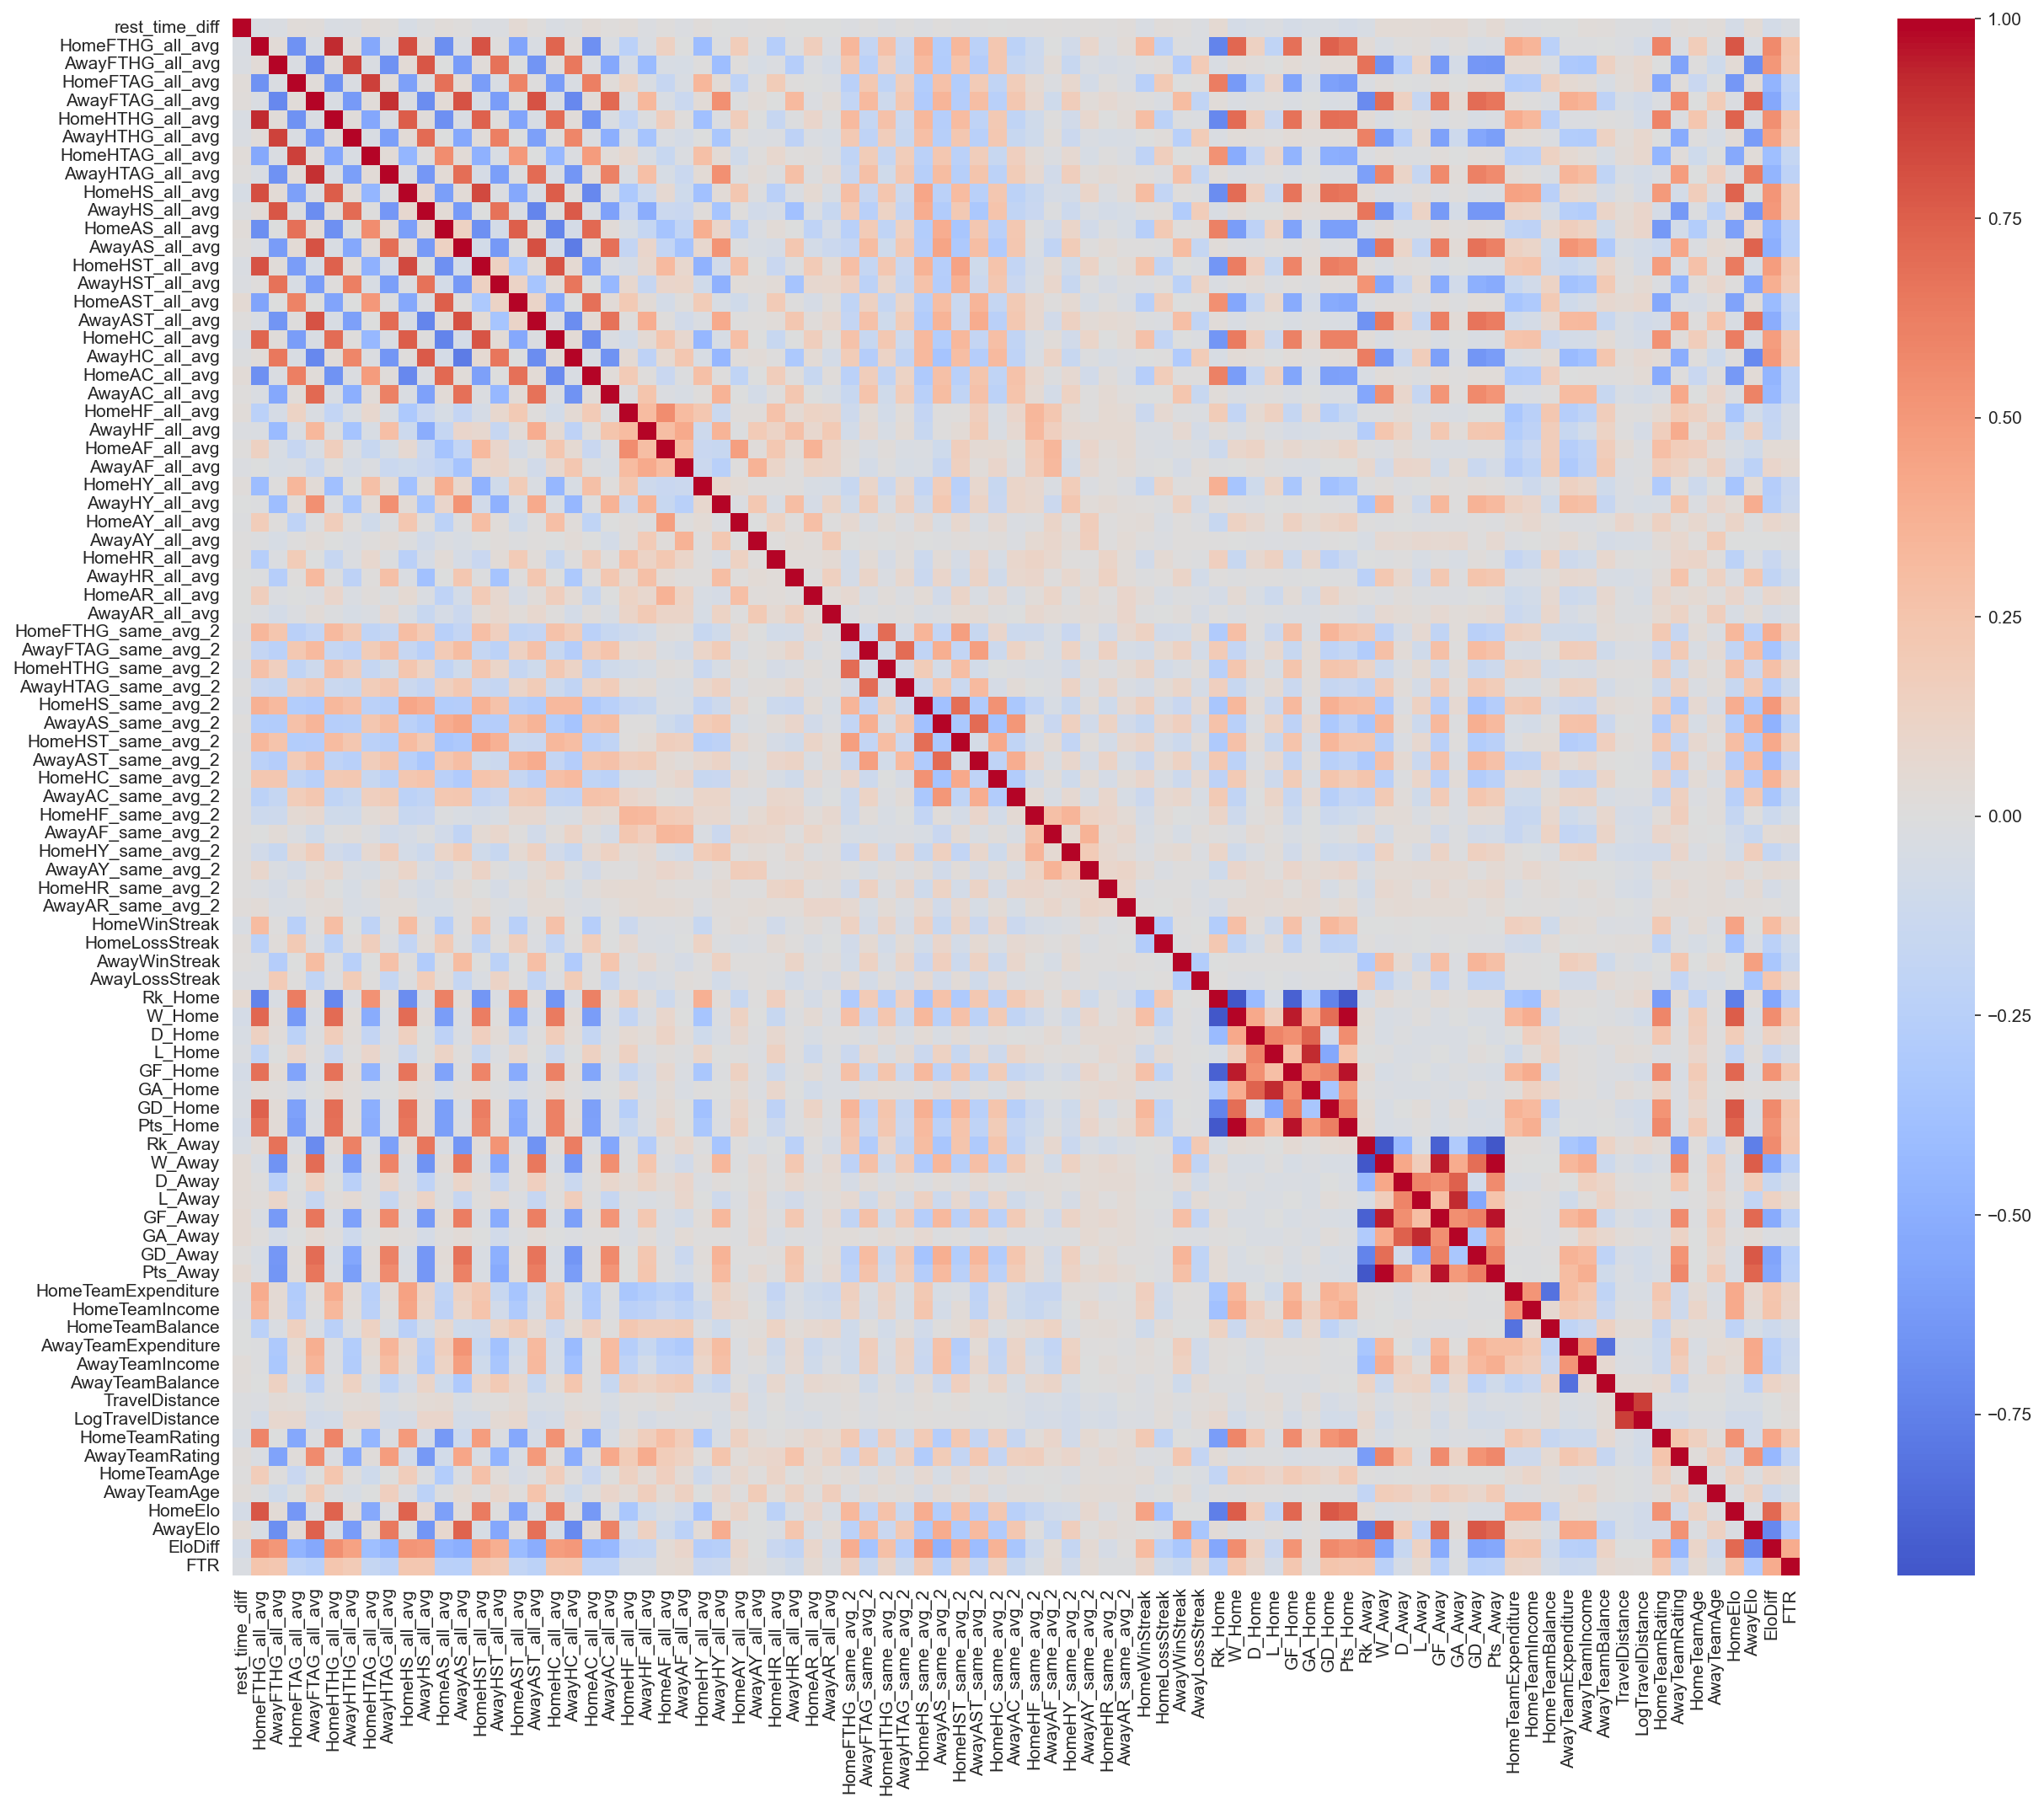

In [30]:
plt.figure(figsize=(20, 16), dpi=150)
sns.heatmap(epl_exploration_df.drop(['HomeTeam', 'AwayTeam', 'Date'], axis=1).dropna().corr(), annot=False, cmap='coolwarm', center=0)
plt.show()

<Axes: >

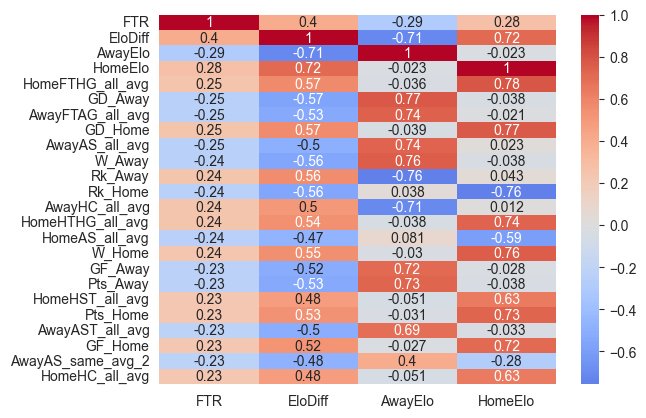

In [32]:
corr_df = epl_exploration_df.drop(['HomeTeam', 'AwayTeam', 'Date'], axis=1).dropna().corr()[['FTR', 'EloDiff', 'AwayElo', 'HomeElo']]
corr_df['FTR_ABS'] = corr_df['FTR'].abs()

sns.heatmap(
    corr_df.sort_values(ascending=False, by='FTR_ABS')
        .drop(['FTR_ABS'], axis=1)[:24], 
    annot=True, 
    cmap='coolwarm', 
    center=0
)

## Save processed data

In [261]:
epl_processed_df_train.to_csv("./processed_data/epl-processed-train.csv", index=False)
epl_processed_df_test.to_csv("./processed_data/epl-processed-test.csv", index=False)

# 4. Methodology Overview

Our methodology consists of the following main components: 
 1). Computing each team's ELO rating and historical averages across each metrics; 
 2). Adding additional features fetched from the internet to the training data and handling the missing values; 
 3). Using SMOTE to create a balanced dataset; 4) Splitting the datasets into train and test set;
 4). Selecting and tuning machine learning classification models with grid search and stratified K-fold cross validation; 
 5). Evaluating and comparing each model's performance on imbalanced/balanced datasets and with all features or with only ELO features.

# 5. Model Training & Validation

## Load processed data

In [25]:
epl_test_df = pd.read_csv("./processed_data/epl-processed-test.csv")
epl_training_df = pd.read_csv("./processed_data/epl-processed-train.csv")
EXCLUDE_COLUMNS = ['Date', 'HomeTeam', 'AwayTeam']
split_index = int(len(epl_training_df) * 0.8)
# split training data into training and validation
epl_training_df, epl_validation_df = epl_training_df[:split_index], epl_training_df[split_index:]

train without additional data

In [11]:
EXTRA_COLS = [ 'Rk_Home', 'W_Home', 'D_Home',
               'L_Home', 'GF_Home', 'GA_Home', 'GD_Home', 'Pts_Home', 'Rk_Away',
               'W_Away', 'D_Away', 'L_Away', 'GF_Away', 'GA_Away', 'GD_Away',
               'Pts_Away', 'HomeTeamExpenditure', 'HomeTeamIncome', 'HomeTeamBalance',
               'AwayTeamExpenditure', 'AwayTeamIncome', 'AwayTeamBalance',
               'TravelDistance', 'LogTravelDistance', 'HomeTeamRating',
               'AwayTeamRating', 'HomeTeamAge', 'AwayTeamAge']
epl_training_df = epl_training_df.drop(EXTRA_COLS, axis=1)
epl_validation_df = epl_validation_df.drop(EXTRA_COLS, axis=1)
epl_test_df = epl_test_df.drop(EXTRA_COLS, axis=1)

train with only elo data

In [3]:
epl_training_df = epl_training_df[['Date', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'EloDiff', 'FTR']]
epl_validation_df = epl_validation_df[['Date', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'EloDiff', 'FTR']]
epl_test_df = epl_test_df[['Date', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'EloDiff', 'FTR']]

## Load functions

In [4]:
# Building pipelines
def build_smote_pipeline(classifier, classifier_params={}):

    return ImbPipeline([
        ('smote', SMOTE()),
        ('classifier', classifier(**classifier_params))
    ])

def add_prefix_to_params(prefix, params):
    return {f"{prefix}__{k}": v for k, v in params.items()}

def perform_grid_search(model_name, model, params, X, y, cv, scoring='accuracy', n_jobs=-1):
    grid = GridSearchCV(model, params, cv=cv, scoring=scoring, n_jobs=n_jobs)
    grid.fit(X, y)
    print(f"{model_name} Grid Search Results:")
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best CV Accuracy: {grid.best_score_:.4f}")

    # Removing the 'classifier__' prefix from the parameter names
    best_params = {k.replace('classifier__', ''): v for k, v in grid.best_params_.items()}
    return best_params

def generate_classification_report(model_name, model, best_params, X_train, y_train, X_test, y_test):
    # Set the best parameters for the model
    model.set_params(**best_params)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Extracting metrics
    metrics = {'model_name': model_name}
    for label, scores in report.items():
        if label in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        label = label.split('.')[0]
        mapping = {
            '0': 'A',
            '1': 'D',
            '2': 'H'
        }
        label = mapping[label]
        metrics[f"{label}_precision"] = scores['precision']
        metrics[f"{label}_recall"] = scores['recall']
        metrics[f"{label}_f1-score"] = scores['f1-score']

    metrics["accuracy"] = report['accuracy']

    return metrics

## Model selection

### ML models

Grid Search - this step takes a long time to run

In [54]:
scaler = StandardScaler()
df = epl_training_df.drop(EXCLUDE_COLUMNS, axis=1)

target_column = 'FTR'
X = df.drop(target_column, axis=1)
X = scaler.fit_transform(X)
y = df[target_column]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model parameters
logistic_params = {'C': [0.1, 1, 10], 'multi_class': ['multinomial'], 'max_iter': [1000]}
forest_params = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}
svm_params = {'C': [0.1, 1, 5], 'kernel': ['linear', 'rbf'], 'probability': [True]}
xgboost_params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'use_label_encoder': [False], 'eval_metric': ['mlogloss']}

logistic_params_prefixed = add_prefix_to_params('classifier', logistic_params)
forest_params_prefixed = add_prefix_to_params('classifier', forest_params)
svm_params_prefixed = add_prefix_to_params('classifier', svm_params)
xgboost_params_prefixed = add_prefix_to_params('classifier', xgboost_params)

logistic_smote_pipeline = build_smote_pipeline(LogisticRegression)
rf_smote_pipeline = build_smote_pipeline(RandomForestClassifier)
svm_smote_pipeline = build_smote_pipeline(SVC)

# # Dictionary to store best parameters for each model
best_params_dict = {}

# Perform grid search for each model and store results
best_params_dict['logistic_smote'] = perform_grid_search("logistic_smote", logistic_smote_pipeline, logistic_params_prefixed, X, y, kf)
best_params_dict['rf_smote'] = perform_grid_search("rf_smote", rf_smote_pipeline, forest_params_prefixed, X, y, kf)
best_params_dict['svm_smote'] = perform_grid_search("svm_smote", svm_smote_pipeline, svm_params_prefixed, X, y, kf)
if USE_XGBOOST:
    xgboost_smote_pipeline = build_smote_pipeline(XGBClassifier)
    best_params_dict['xgboost_smote'] = perform_grid_search("xgboost_smote", xgboost_smote_pipeline, xgboost_params_prefixed, X, y, kf)

best_params_dict['logistic'] = perform_grid_search("logistic", LogisticRegression(), logistic_params, X, y, kf)
best_params_dict['rf'] = perform_grid_search("rf", RandomForestClassifier(), forest_params, X, y, kf)
best_params_dict['svm'] = perform_grid_search("svm", SVC(), svm_params, X, y, kf)
if USE_XGBOOST:
    best_params_dict['xgboost'] = perform_grid_search("xgboost", XGBClassifier(), xgboost_params, X, y, kf)
best_params_dict

logistic_smote Grid Search Results:
Best Parameters: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__multi_class': 'multinomial'}
Best CV Accuracy: 0.4939
rf_smote Grid Search Results:
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV Accuracy: 0.4795
svm_smote Grid Search Results:
Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'linear', 'classifier__probability': True}
Best CV Accuracy: 0.4786
xgboost_smote Grid Search Results:
Best Parameters: {'classifier__eval_metric': 'mlogloss', 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__use_label_encoder': False}
Best CV Accuracy: 0.4676
logistic Grid Search Results:
Best Parameters: {'C': 0.1, 'max_iter': 1000, 'multi_class': 'multinomial'}
Best CV Accuracy: 0.5335
rf Grid Search Results:
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Accuracy: 0.5347
svm Grid Search Resul

{'logistic_smote': {'C': 0.1, 'max_iter': 1000, 'multi_class': 'multinomial'},
 'rf_smote': {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100},
 'svm_smote': {'C': 1, 'kernel': 'linear', 'probability': True},
 'xgboost_smote': {'eval_metric': 'mlogloss',
  'max_depth': 3,
  'n_estimators': 100,
  'use_label_encoder': False},
 'logistic': {'C': 0.1, 'max_iter': 1000, 'multi_class': 'multinomial'},
 'rf': {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100},
 'svm': {'C': 5, 'kernel': 'rbf', 'probability': True},
 'xgboost': {'eval_metric': 'mlogloss',
  'max_depth': 3,
  'n_estimators': 100,
  'use_label_encoder': False}}

save best params

In [55]:
with open('./models/best_params_dict.pkl', 'wb') as f:
    pickle.dump(best_params_dict, f)

### Neural Network

Multi-Layer Perceptron (MLP) 

model definition

In [27]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class MLP(nn.Module):
    def __init__(self, input_dim, layer_num, output_dim, hidden_dim, dropout_prob=0.4):
        super(MLP, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_prob))

        # Hidden layers
        for _ in range(layer_num - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.layers = nn.Sequential(*layers)

    def forward(self, input):
        for layer in self.layers:
            input = layer(input)
        return input

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

parameters

In [28]:
INPUT_DIM = len(epl_training_df.drop(EXCLUDE_COLUMNS, axis=1).columns) - 1 # Number of features
OUTPUT_DIM = 3  # For three categories
LAYER_NUM = 5  # Number of layers
HIDDEN_DIM = 40  # Number of neurons in hidden layer
LEARNING_RATE = 0.001
EPOCHS = 30
WEIGHT_DECAY = 1e-2  # L2 regularization factor
BATCH_SIZE = 64

training

In [29]:
def train_mlp(train_X, train_y, input_dim=INPUT_DIM, layer_num=LAYER_NUM, output_dim=OUTPUT_DIM, hidden_dim=HIDDEN_DIM, learning_rate=LEARNING_RATE, epochs=EPOCHS, weight_decay=WEIGHT_DECAY, batch_size=BATCH_SIZE, use_smote=False):
    # Apply SMOTE to the training set to balance it
    
    if use_smote:
        smote = SMOTE(random_state=42)
        train_X, train_y = smote.fit_resample(train_X, train_y)
    train_X, train_y = torch.tensor(train_X, dtype=torch.float32).to(DEVICE), torch.tensor(train_y, dtype=torch.long).to(DEVICE)
    mlp = MLP(input_dim, layer_num, output_dim, hidden_dim).to(DEVICE)
    optimizer = optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    train_dataset = CustomDataset(train_X, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        # Training Phase
        mlp.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = mlp(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
    return mlp

def model_predict(model, test_X):
    model.eval()
    test_X = torch.tensor(test_X, dtype=torch.float32).to(DEVICE)
    y_pred = model(test_X)
    y_pred = y_pred.cpu().detach().numpy()
    return np.argmax(y_pred, axis=1)

def model_accuracy(model, test_X, test_y):
    
    test_X, test_y = torch.tensor(test_X, dtype=torch.float32).to(DEVICE), torch.tensor(test_y, dtype=torch.long).to(DEVICE)
    y_pred = model(test_X)
    y_test, y_pred = test_y.cpu().numpy(), y_pred.cpu().detach().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [101]:
df = epl_training_df.drop(EXCLUDE_COLUMNS, axis=1)

X = df.drop(['FTR'], axis=1).values
y = df['FTR'].values  # 4th column (index 3)

scaler = StandardScaler()
X = scaler.fit_transform(X)

mapping = {
    'H': 2,
    'D': 1,
    'A': 0
}

# Initial train-test split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_smote = train_mlp(train_X, train_y, use_smote=True)
print(f"Accuracy of mlp_smote: {model_accuracy(mlp_smote, test_X, test_y):.4f}")
mlp = train_mlp(train_X, train_y)
print(f"Accuracy of mlp: {model_accuracy(mlp, test_X, test_y):.4f}")

Accuracy of mlp_smote: 0.4869
Accuracy of mlp: 0.5416


save the MLP model

In [93]:
torch.save(mlp.state_dict(), './models/mlp.pth')
torch.save(mlp_smote.state_dict(), './models/mlp_smote.pth')

## Evaluate models

### Load best params

In [8]:
with open('./models/best_params_dict.pkl', 'rb') as f:
    best_params_dict = pickle.load(f)
best_params_dict

{'logistic_smote': {'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial'},
 'rf_smote': {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200},
 'svm_smote': {'C': 1, 'kernel': 'rbf', 'probability': True},
 'xgboost_smote': {'eval_metric': 'mlogloss',
  'max_depth': 5,
  'n_estimators': 100,
  'use_label_encoder': False},
 'logistic': {'C': 10, 'max_iter': 1000, 'multi_class': 'multinomial'},
 'rf': {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100},
 'xgboost': {'eval_metric': 'mlogloss',
  'max_depth': 3,
  'n_estimators': 100,
  'use_label_encoder': False},
 'svm': {'C': 0.1, 'kernel': 'linear', 'probability': True}}

### Load models

In [31]:
from functools import partial

# List of models to evaluate
models = [
    ('logistic', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svm', SVC()),
    ('xgboost', XGBClassifier()),
    ('logistic_smote', build_smote_pipeline(LogisticRegression)),
    ('rf_smote', build_smote_pipeline(RandomForestClassifier)),
    ('svm_smote', build_smote_pipeline(SVC)),
    ('xgboost_smote', build_smote_pipeline(XGBClassifier)),
    ('mlp', train_mlp),
    ('mlp_smote', partial(train_mlp, use_smote=True))
]
NN_MODELS = ['mlp', 'mlp_smote']
best_params_prefixed = {}
for key, val in best_params_dict.items():
    if 'smote' in key:
        best_params_prefixed[key] = add_prefix_to_params('classifier', val)
    else:
        best_params_prefixed[key] = val

### Cross Validation

In [104]:
# Assuming X and y are your features and target variable
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

df = epl_training_df.dropna()
X, y = df.drop(EXCLUDE_COLUMNS + ['FTR'], axis=1), df['FTR']
scaler = StandardScaler()
X = scaler.fit_transform(X)

# DataFrame to store results
results_df = pd.DataFrame()
mapping = {
    '1': 'A',
    '2': 'D',
    '3': 'H'
}

NN_MODELS = ['mlp', 'mlp_smote']

for model_name, model in tqdm(models):
    # Set the best parameters for the model
    if model_name in best_params_prefixed:
        model.set_params(**best_params_prefixed[model_name])

    for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X, y))):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index].to_numpy(), y[test_index].to_numpy()

        # Fit and predict
        if model_name in NN_MODELS:
            model_fitted = model(X_train, y_train)
            model_fitted.eval()
            y_pred = model_predict(model_fitted, X_test)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Record scores
        accuracy = accuracy_score(y_test, y_pred)
        f1_scores = f1_score(y_test, y_pred, average=None)  # F1 scores for each class
        precision_scores = precision_score(y_test, y_pred, average=None, zero_division=0)  # Precision for each class
        recall_scores = recall_score(y_test, y_pred, average=None, zero_division=0)  # Recall for each class

        # Prepare fold results as a DataFrame
        fold_results = pd.DataFrame({'model_name': model_name,
                                     'Fold': fold + 1,
                                     'Accuracy': accuracy}, index=[0])
        for i, (f1, precision, recall) in enumerate(zip(f1_scores, precision_scores, recall_scores), start=1):
            class_label = mapping[str(i)]
            fold_results[f'F1_{class_label}'] = f1
            fold_results[f'Precision_{class_label}'] = precision
            fold_results[f'Recall_{class_label}'] = recall

        # Append to the results DataFrame
        results_df = pd.concat([results_df, fold_results], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]
5it [00:00, 66.34it/s]

0it [00:00, ?it/s]
1it [00:00,  1.89it/s]
2it [00:01,  1.02it/s]
3it [00:02,  1.10it/s]
4it [00:03,  1.21it/s]
5it [00:04,  1.22it/s]
 20%|██        | 2/10 [00:04<00:16,  2.09s/it]
0it [00:00, ?it/s]
1it [00:08,  8.75s/it]
2it [00:16,  7.95s/it]
3it [00:24,  8.24s/it]
4it [00:32,  8.00s/it]
5it [00:39,  7.92s/it]
 30%|███       | 3/10 [00:43<02:04, 17.72s/it]
0it [00:00, ?it/s]
1it [00:00,  8.08it/s]
2it [00:00,  7.86it/s]
3it [00:00,  7.59it/s]
4it [00:00,  7.06it/s]
5it [00:00,  7.49it/s]
 40%|████      | 4/10 [00:44<01:08, 11.36s/it]
0it [00:00, ?it/s]
5it [00:00, 34.81it/s]
 50%|█████     | 5/10 [00:44<00:37,  7.46s/it]
0it [00:00, ?it/s]
1it [00:00,  1.60it/s]
2it [00:01,  1.60it/s]
3it [00:01,  1.57it/s]
4it [00:02,  1.60it/s]
5it [00:03,  1.56it/s]
 60%|██████    | 6/10 [00:47<00:24,  6.05s/it]
0it [00:00, ?it/s]
1it [00:05,  5.84s/it]
2it [00:11,  5.84s/it]
3it [00:17,  5.80s/it]
4it [00:23,  5.76s/it]
5it [00:28,  

In [105]:
cv_df = results_df.drop('Fold', axis=1)

cv_df

,model_name,Accuracy,F1_A,Precision_A,Recall_A,F1_D,Precision_D,Recall_D,F1_H,Precision_H,Recall_H
0,logistic,0.543143,0.520436,0.520436,0.520436,0.000000,0.000000,0.000000,0.669271,0.552095,0.849587
1,logistic,0.540062,0.516824,0.512000,0.521739,0.000000,0.000000,0.000000,0.666667,0.551463,0.842715
2,logistic,0.524653,0.494087,0.478372,0.510870,0.000000,0.000000,0.000000,0.653413,0.544751,0.816225
3,logistic,0.523516,0.456036,0.503289,0.416894,0.000000,0.000000,0.000000,0.658735,0.529708,0.870861
4,logistic,0.552814,0.516484,0.520776,0.512262,0.000000,0.000000,0.000000,0.687013,0.565171,0.875828
5,rf,0.543914,0.507983,0.543478,0.476839,0.000000,0.000000,0.000000,0.671727,0.544057,0.877686
6,rf,0.536210,0.488688,0.549153,0.440217,0.006042,0.200000,0.003067,0.665418,0.534068,0.882450
7,rf,0.526194,0.492997,0.508671,0.478261,0.000000,0.000000,0.000000,0.652510,0.533684,0.839404
8,rf,0.518890,0.442338,0.526316,0.381471,0.000000,0.000000,0.000000,0.651988,0.516974,0.882450
9,rf,0.545104,0.486726,0.530547,0.449591,0.000000,0.000000,0.000000,0.682620,0.550813,0.897351


### Final validation with validation set

In [113]:
df = epl_training_df.dropna()
df_validation = epl_validation_df.dropna()
X_train, y_train = df.drop(EXCLUDE_COLUMNS + ['FTR'], axis=1), df['FTR']
X_test, y_test = df_validation.drop(EXCLUDE_COLUMNS + ['FTR'], axis=1), df_validation['FTR']
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# DataFrame to store results
results_df = pd.DataFrame()
mapping = {
    '1': 'A',
    '2': 'D',
    '3': 'H'
}

for model_name, model in tqdm(models):
    # Set the best parameters for the model
    if model_name in best_params_prefixed:
        model.set_params(**best_params_prefixed[model_name])

    # Fit and predict
    if model_name in NN_MODELS:
        try:
            model_fitted = model(X_train, y_train)
            model_fitted.eval()
            y_pred = model_predict(model_fitted, X_test)
        except RuntimeError as e:
            print(f"RuntimeError for {model_name}: {e}")
            continue
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Record scores
    accuracy = accuracy_score(y_test, y_pred)
    f1_scores = f1_score(y_test, y_pred, average=None)  
    precision_scores = precision_score(y_test, y_pred, average=None, zero_division=0) 
    recall_scores = recall_score(y_test, y_pred, average=None, zero_division=0) 

    # Prepare model results as a DataFrame
    model_results = pd.DataFrame({'model_name': model_name,
                                  'Accuracy': accuracy}, index=[0])
    for i, (f1, precision, recall) in enumerate(zip(f1_scores, precision_scores, recall_scores), start=1):
        class_label = mapping[str(i)]
        model_results[f'F1_{class_label}'] = f1
        model_results[f'Precision_{class_label}'] = precision
        model_results[f'Recall_{class_label}'] = recall

    results_df = pd.concat([results_df, model_results], ignore_index=True)



100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


# 6. Results

## CV results

### Barplot

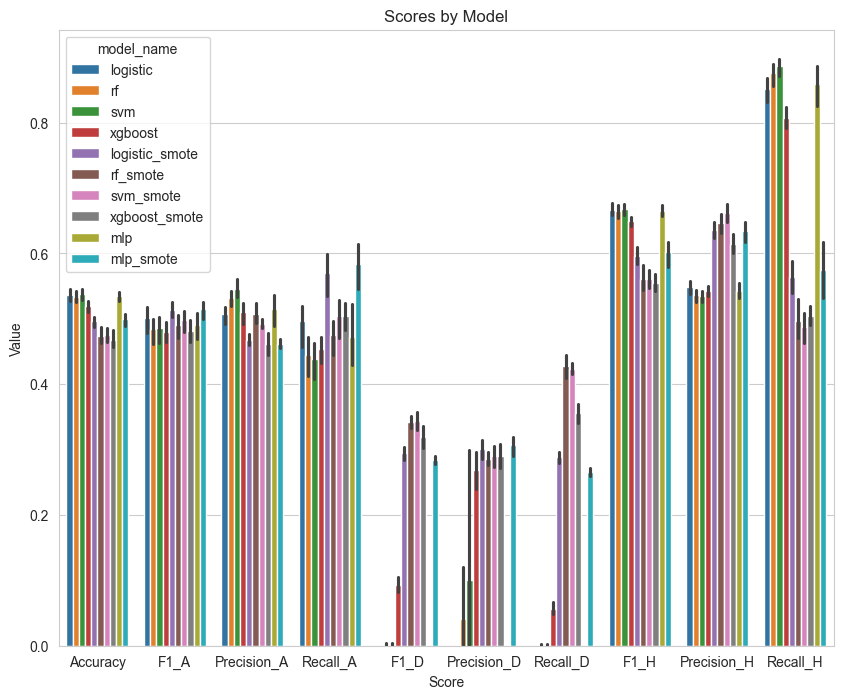

In [106]:
# Melting the DataFrame to have scores in a single column and their names in another
df_melted = cv_df.melt(id_vars='model_name', var_name='Score', value_name='Value')

plt.figure(figsize=(10, 8))
sns.barplot(x='Score', y='Value', hue='model_name', data=df_melted)
plt.title('Scores by Model')
plt.show()

### Heatmap

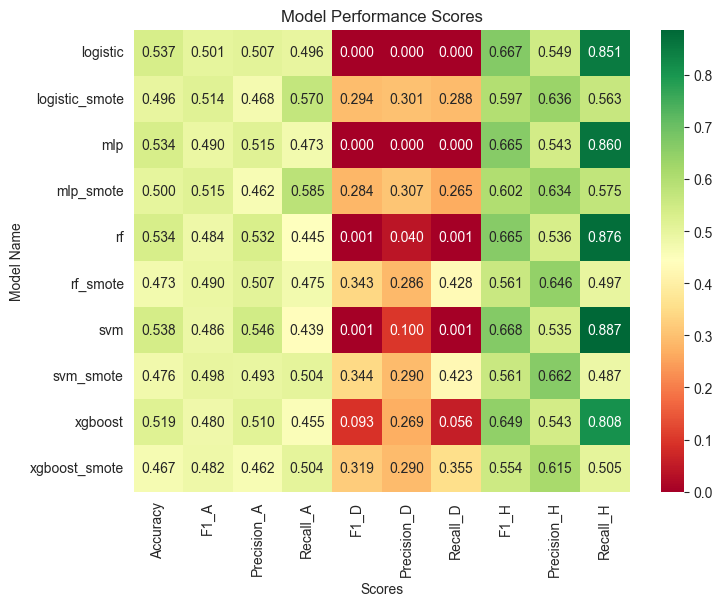

In [107]:
cv_mean_df = cv_df.groupby('model_name').mean().reset_index()
cv_mean_df.set_index('model_name', inplace=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cv_mean_df, annot=True, cmap="RdYlGn", fmt=".3f")

plt.title('Model Performance Scores')
plt.xlabel('Scores')
plt.ylabel('Model Name')

plt.show()

## Validation results

### Barplot

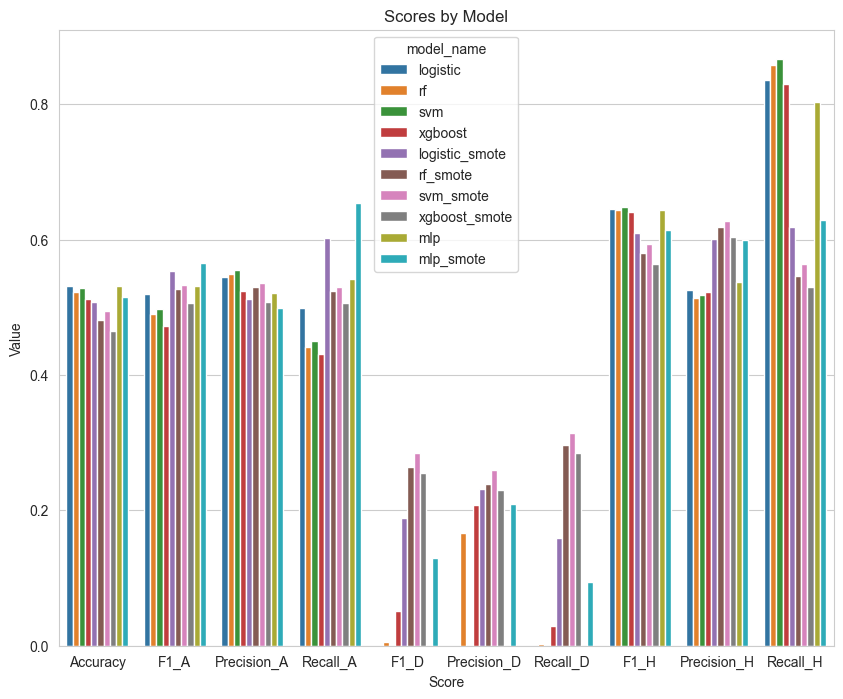

In [114]:
if 'Fold' in results_df.columns:
    results_df = results_df.drop('Fold', axis=1)

# Melting the DataFrame to have scores in a single column and their names in another
df_melted = results_df.melt(id_vars='model_name', var_name='Score', value_name='Value')

plt.figure(figsize=(10, 8))
sns.barplot(x='Score', y='Value', hue='model_name', data=df_melted)
plt.title('Scores by Model')
plt.show()

### Heatmap

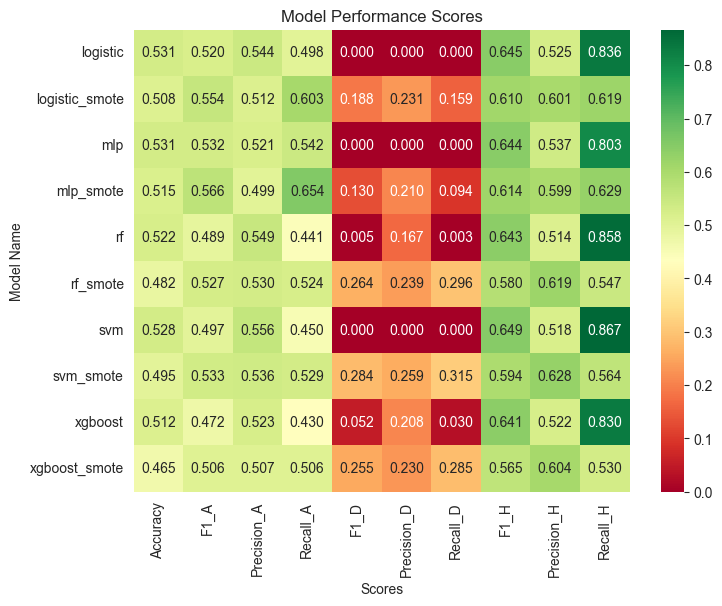

In [115]:
result_mean_df = results_df.groupby('model_name').mean().reset_index()
result_mean_df.set_index('model_name', inplace=True)

plt.figure(figsize=(8, 6))
sns.heatmap(result_mean_df, annot=True, cmap="RdYlGn", fmt=".3f")

plt.title('Model Performance Scores')
plt.xlabel('Scores')
plt.ylabel('Model Name')

plt.show()

# 7. Final Predictions on Test Set

train on all training data and test on test data

In [32]:
stander_scaler = StandardScaler()

X, y = epl_training_df.drop(EXCLUDE_COLUMNS + ['FTR'], axis=1), epl_training_df['FTR']
X_test = epl_test_df.drop(EXCLUDE_COLUMNS + ['FTR'], axis=1)
X = stander_scaler.fit_transform(X)
X_test = stander_scaler.transform(X_test)
results_df = epl_test_df[['Date', 'HomeTeam', 'AwayTeam']]
mapping = {
    '0': 'A',
    '1': 'D',
    '2': 'H',
}
results = {} 
for model_name, model in tqdm(models):
    # Set the best parameters for the model
    if model_name in best_params_prefixed:
        model.set_params(**best_params_prefixed[model_name])
    if model_name in NN_MODELS:
        model_fitted = model(X, y)
        model_fitted.eval()
        y_pred = model_predict(model_fitted, X_test)
    else:
        model.fit(X, y)
        y_pred = model.predict(X_test)
    results[model_name] = y_pred
    results[model_name] = pd.Series(results[model_name]).apply(lambda x: mapping[str(x).split('.')[0]])

results_df = pd.concat([results_df, pd.DataFrame(results)], axis=1)
results_df

100%|██████████| 10/10 [01:51<00:00, 11.19s/it]


,Date,HomeTeam,AwayTeam,logistic,rf,svm,xgboost,logistic_smote,rf_smote,svm_smote,xgboost_smote,mlp,mlp_smote
0,2024-02-03,Everton,Tottenham,A,A,A,A,A,A,H,A,A,A
1,2024-02-03,Chelsea,Wolves,H,H,H,H,H,H,H,H,H,H
2,2024-02-03,Man United,West Ham,H,H,H,H,H,H,H,D,H,H
3,2024-02-03,Burnley,Fulham,H,H,H,H,A,D,H,H,H,D
4,2024-02-03,Newcastle,Luton,H,H,H,H,H,H,H,H,H,H
5,2024-02-03,Brentford,Man City,A,A,A,A,A,A,A,A,A,A
6,2024-02-03,Arsenal,Liverpool,H,H,H,H,H,D,D,H,H,H
7,2024-02-03,Bournemouth,Nott'm Forest,H,H,H,H,A,H,H,H,H,D
8,2024-02-03,Brighton,Crystal Palace,H,H,H,H,H,H,H,H,H,H
9,2024-02-03,Sheffield United,Aston Villa,A,A,A,A,A,A,A,A,A,A


In [33]:
# Reversing the name unifying dictionary
train_to_test_team_name = {'Bournemouth': 'AFC Bournemouth',
                           'Arsenal': 'Arsenal',
                           'Brentford': 'Brentford',
                           'Brighton': 'Brighton',
                           'Burnley': 'Burnley',
                           'Chelsea': 'Chelsea',
                           'Everton': 'Everton',
                           'Man United': 'Man Utd',
                           'Newcastle': 'Newcastle',
                           'Sheffield United': 'Sheff Utd',
                           "Nott'm Forest": 'Nottingham Forest',
                           'Liverpool': 'Liverpool',
                           'Man City': 'Man City',
                           'Crystal Palace': 'Crystal Palace',
                           'Fulham': 'Fulham',
                           'Wolves': 'Wolves',
                           'Tottenham': 'Spurs',
                           'West Ham': 'West Ham',
                           'Luton': 'Luton Town',
                           'Aston Villa': 'Aston Villa'}
# Majority vote
results_df['FTR'] = results_df.drop(EXCLUDE_COLUMNS, axis=1).mode(axis=1)[0]
final_predictions = results_df[[*EXCLUDE_COLUMNS, 'FTR']]
final_predictions.loc[:, ['HomeTeam', 'AwayTeam']] = final_predictions[['HomeTeam', 'AwayTeam']].map(lambda x: train_to_test_team_name[x])
final_predictions

,Date,HomeTeam,AwayTeam,FTR
0,2024-02-03,Everton,Spurs,A
1,2024-02-03,Chelsea,Wolves,H
2,2024-02-03,Man Utd,West Ham,H
3,2024-02-03,Burnley,Fulham,H
4,2024-02-03,Newcastle,Luton Town,H
5,2024-02-03,Brentford,Man City,A
6,2024-02-03,Arsenal,Liverpool,H
7,2024-02-03,AFC Bournemouth,Nottingham Forest,H
8,2024-02-03,Brighton,Crystal Palace,H
9,2024-02-03,Sheff Utd,Aston Villa,A


save the final prediction csv

In [34]:
final_predictions.to_csv("./submission.csv", index=False)